In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from datetime import datetime
from keras.layers import GRU


In [2]:
from binance.client import Client
api_key = 'xVM7IUXNFne6yrZyGnHM605GdDUCQaoumMv8sEfKO6LeMdpo9XfzeoDgGOalhjoi'
secret = 'OhAFhj9WccUT1N3qrpJiXERXvI1PbsOVx6GgWAZmH7HgYr775l7N286CFQ4ZKh7B'
client = Client(api_key, secret)

In [3]:
candles = client.get_klines(symbol = 'BTCUSDT', interval = Client.KLINE_INTERVAL_30MINUTE) 

len(candles)

500

In [4]:
candles[499]

[1622413800000,
 '35911.33000000',
 '35911.34000000',
 '35750.00000000',
 '35750.01000000',
 '427.12169500',
 1622415599999,
 '15290764.27108320',
 8715,
 '147.76228800',
 '5289614.44077156',
 '0']

In [5]:
price = np.array([float(candles[i][4]) for i in range(500)])

time = np.array([int(candles[i][0]) for i in range(500)])

t = np.array([datetime.fromtimestamp(time[i]/1000).strftime('%H:%M:%S') for i in range(500)])

In [6]:
price.shape

(500,)

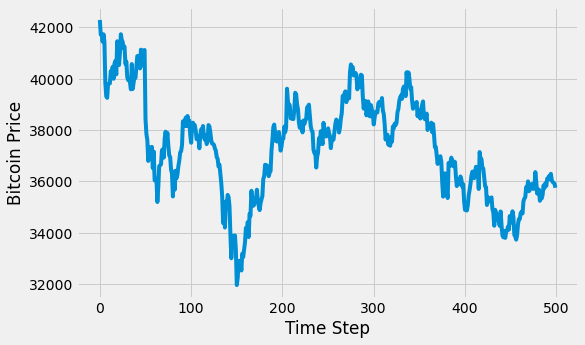

In [7]:
plt.figure(figsize = (8,5));
plt.xlabel('Time Step');
plt.ylabel('Bitcoin Price')
plt.plot(price);

In [8]:
timeframe = pd.DataFrame({'Time':t, 'Price $BTC': price})
timeframe

,Time,Price $BTC
0,09:00:00,42281.81
1,09:30:00,41713.33
2,10:00:00,41714.99
3,10:30:00,41439.32
4,11:00:00,41724.15
...,...,...
495,16:30:00,36050.00
496,17:00:00,35974.96
497,17:30:00,35940.45
498,18:00:00,35911.34


In [10]:
price = price.reshape(500,1)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(price[:374])

price = scaler.transform(price)

df = pd.DataFrame(price.reshape(100,5), columns = ['First', 'Second', 'Third', 'Fourth', 'Target'])
# Here First, Second, Third, Fourth are the seconds over which it is trained 
# and target is the value which will be predicted

df.head()

,First,Second,Third,Fourth,Target
0,2.293393,1.992329,1.993208,1.847215,1.998059
1,1.843804,1.000441,0.720492,0.687710,0.971287
2,0.984304,0.985310,1.239717,1.146413,1.326925
3,1.081183,1.389338,1.449574,1.171230,1.853787
4,1.607991,1.363864,1.615501,1.998822,1.878911


## Train Test Split 

In [13]:
# 75% train, 25% test

x_train = df.iloc[:74, :4]
y_train = df.iloc[:74, -1]

x_test = df.iloc[75:99,:4]
y_test = df.iloc[75:99,-1]

In [14]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [15]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train.shape , x_test.shape

((74, 4, 1), (24, 4, 1))

In [18]:
model = Sequential()

model.add(GRU(256, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 256)               198912    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 199,169
Trainable params: 199,169
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x_train, y_train, batch_size=5, epochs = 100)

Epoch 1/100
15/15 [==============================] - 11s 4ms/step - loss: 0.6255
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1468
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.1106
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0717
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0726
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0787
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0562
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0679
Epoch 12/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0463
Epoch 13/100
15/15 [================

In [20]:
y_pred = model.predict(x_test)

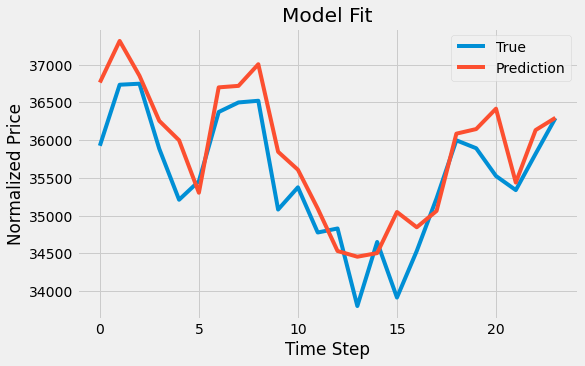

In [21]:
# we need to inverse tranform to check the original values, since we had scaled it previously

plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred), label='Prediction')
plt.legend()

In [23]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred)))
print ('Test Score {} RMSE WITH GRU'.format(testScore))

Test Score 495.8217140600466 RMSE WITH GRU
